In [1]:
# general tools
import sys
from glob import glob
from os.path import basename
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# stats tools
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
import data_utils as du
import verif_utils as vu
import pipeline_utils as pu
from namelist import * 

In [2]:
import importlib
importlib.reload(vu)

<module 'verif_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/verif_utils.py'>

In [3]:
var = 'TMAX'
with h5py.File(PRISM_dir+'PRISM_{}_features_2015_2020.hdf'.format(var), 'r') as hdf_io:
    T_4km = hdf_io['{}_4km'.format(var)][...]
    T_REGRID = hdf_io['{}_REGRID'.format(var)][...]
    T_CLIM_4km = hdf_io['{}_CLIM_4km'.format(var)][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    # lat/lon
    land_mask = hdf_io['land_mask'][...]
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]

In [4]:
# train date range
base = datetime(2015, 1, 1, 0)
seasons = ['djf', 'mam', 'jja', 'son']
N_days = 365 + 366 + 365 # 2015-2018 (period ending)
N_pred = 365 + 365 # 2018-2020 (period ending)
train_list = [base + timedelta(days=x) for x in range(N_days)]
valid_list = [base + timedelta(days=x) for x in range(N_pred)]
# inds
IND_train  = pu.season_ind_sep(train_list, key_format='{}')
IND_valid  = pu.season_ind_sep(valid_list, key_format='{}')
# allocation
grid_shape = land_mask.shape

OUT_no_clim = np.zeros((N_pred,)+grid_shape)
OUT_with_clim = np.zeros((N_pred,)+grid_shape)

# separate by seasons
for sea in seasons:
    # inds
    ind_train_temp = IND_train[sea]
    ind_valid_temp = IND_valid[sea]
    
    # no climatology input
    Y = T_4km[ind_train_temp, ...]
    X_3d = (T_REGRID[ind_train_temp, ...],)
    X_2d = (etopo_4km, etopo_regrid)
    X_3d_pred = (T_REGRID[ind_valid_temp, ...],)
    X_2d_pred = (etopo_4km, etopo_regrid)
    OUT_no_clim[ind_valid_temp, ...] = vu.baseline_estimator(X_3d, X_2d, Y, X_3d_pred, X_2d_pred, land_mask, method='norm_std')
    
    # with climatology input
    X_3d = (T_REGRID[ind_train_temp, ...], T_CLIM_4km[ind_train_temp, ...])
    X_3d_pred = (T_REGRID[ind_valid_temp, ...], T_CLIM_4km[ind_valid_temp, ...])
    OUT_with_clim[ind_valid_temp, ...] = vu.baseline_estimator(X_3d, X_2d, Y, X_3d_pred, X_2d_pred, land_mask, method='norm_std')
    

In [46]:
T_REGRID[ind_valid_temp, ...].shape

(180, 600, 600)

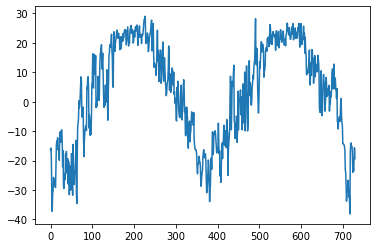

In [62]:
plt.plot(OUT[-N_pred:, 599, 599])

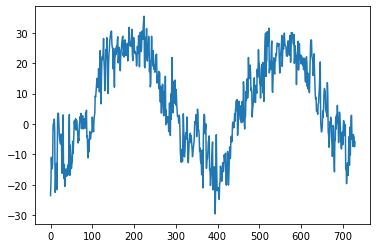

In [64]:
plt.plot(T_4km[-N_pred:, 599, 599])

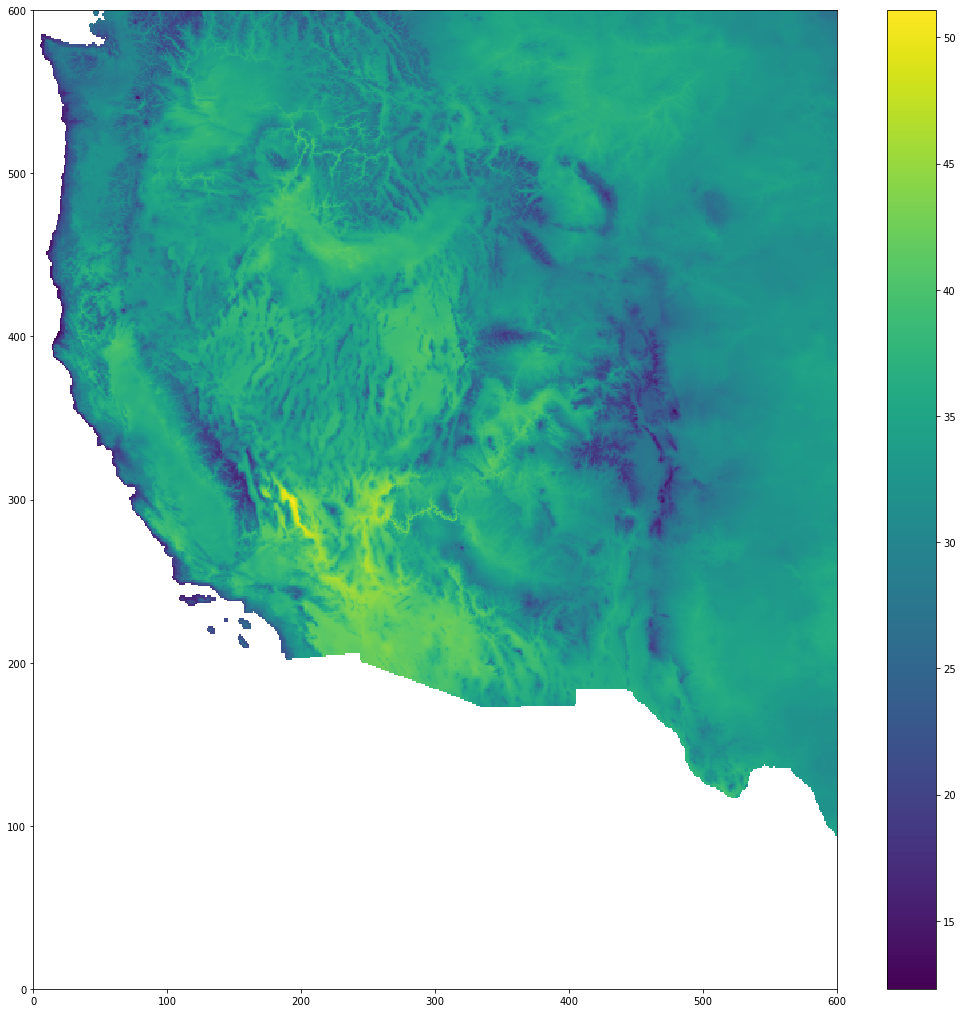

In [5]:
plt.figure(figsize=(18, 18))
plt.pcolormesh(OUT_no_clim[180, ...])
plt.colorbar()

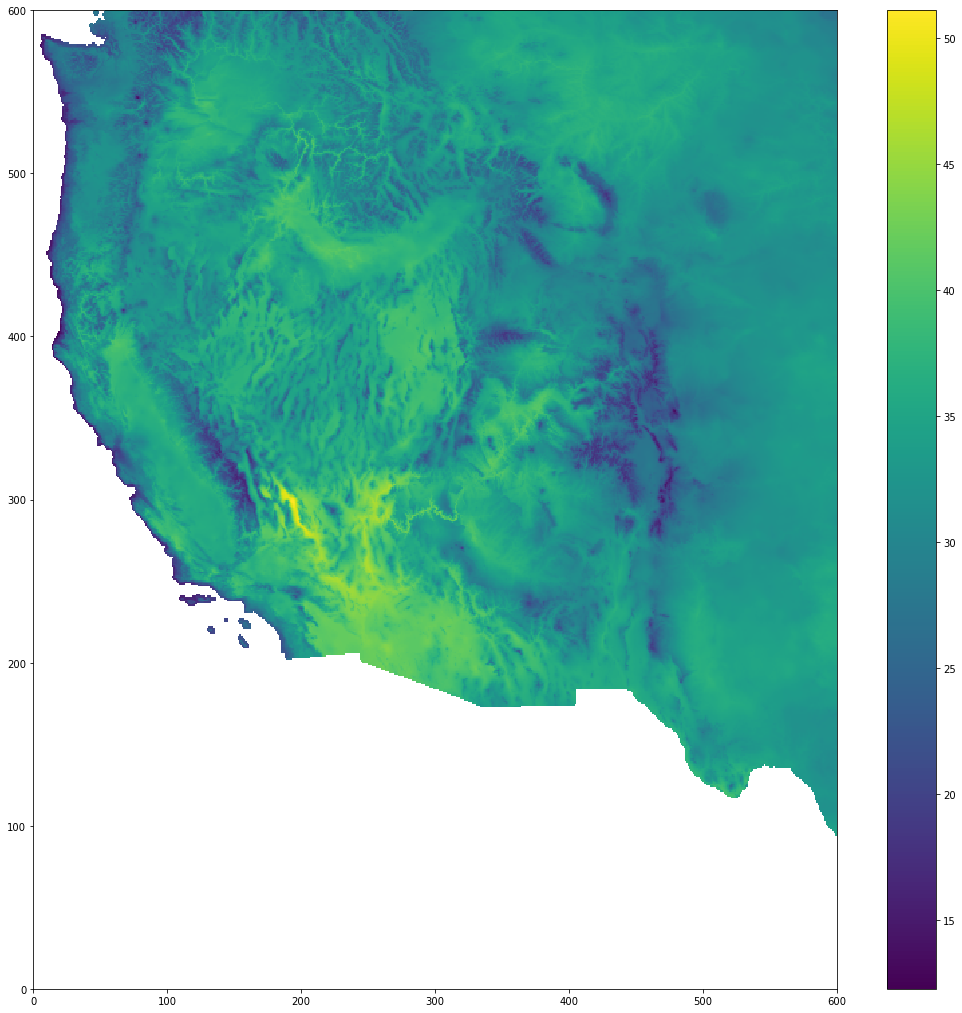

In [6]:
plt.figure(figsize=(18, 18))
plt.pcolormesh(OUT_with_clim[180, ...])
plt.colorbar()